In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from pybedtools import BedTool
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os

In [7]:
def extract_binding_sequences(bed_file, fasta_file, output_fasta):

    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    bed = BedTool(bed_file)

    records = []

    for i, interval in enumerate(bed):
        chrom = interval.chrom
        start = int(interval.start)
        end = int(interval.end)

        seq = genome[chrom].seq[start:end] 
        record = SeqRecord(seq, id=f"{chrom}:{start}-{end}", description="")
        records.append(record.upper())

    SeqIO.write(records, output_fasta, "fasta")
 
def extract_binding_sequences_center(bed_file, fasta_file, output_fasta, length):

    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    bed = BedTool(bed_file)

    records = []

    for i, interval in enumerate(bed):
        chrom = interval.chrom
        start = int(interval.start)
        end = int(interval.end)
        center = (start + end) // 2
        center_start = center - (length//2)
        center_end = center + (length//2)

        seq = genome[chrom].seq[center_start:center_end] 
        record = SeqRecord(seq, id=f"{chrom}:{center_start}-{center_end}", description="")
        records.append(record.upper())

    SeqIO.write(records, output_fasta, "fasta")
 

In [9]:
extract_binding_sequences_center("jun_np_chr22_GRCh38.bed", "chr22_GRCh28.fasta", "jun_np_chr22.fasta", 100)

Ejercicio 5.2: 

a) genere los 3 sets de secuencias negativas. Para el conjunto N3 (seceencias
del genoma que NO unen el FT) puede en primer lugar tomar secuencias (de largo fijo)
adyacentes y/o a “n” nt de distancia del sitio de union del FP. Alternativamente puede
seleccionar secuencias del Chr22 al azar (o puede probar ambas).

b) escriba el codigo para a partir del fasta con las secuencias de ADN ls convierta en un tensor
de pytorch de dimension Nseqs, 4, largo Seq

c) integre al codigo “b” la opciòn de hacer “0” padding y/o recorte las secuencias a un largo fijo.

d) Escriba el codigo que genera ademas el tensor que posee la clasificaciòn real de la
secuencia en si une (y_true=1) (o no, y_true=0) el FT. Usualmente a este tensor se lo llama
y_true.

In [133]:
def one_hot_encoding(sequence):

    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq_len = len(sequence)
    encoding = np.zeros((4, seq_len), dtype=np.float32)

    indices = np.array([mapping.get(base, 4) for base in sequence])

    valid_indices = indices[indices < 4]  # Exclude 'N' positions
    encoding[valid_indices, np.arange(seq_len)[indices < 4]] = 1.0

    n_positions = (indices == 4)
    encoding[:, n_positions] = 0.25

    return torch.Tensor(encoding)


def dinucleotide_shuffle(sequence):
    
    dinucleotides = [sequence[i:i+2] for i in range(0, len(sequence), 2)]
    np.random.shuffle(dinucleotides)
    shuffled_sequence_str = ''.join(dinucleotides)
    
    return shuffled_sequence_str

def padding(one_hot_sequence, len = 100):

    L = one_hot_sequence.shape[1]
    pad_total = len - L
    pad_left = pad_total // 2
    pad_right = pad_total - pad_left
        
    pad_tensor = torch.nn.functional.pad(one_hot_sequence, (pad_left, pad_right), mode='constant', value=0)
   
    return pad_tensor

def generate_dna_sequences(num_sequences, sequence_length=100, seed=None):
    if seed is not None:
        random.seed(seed)

    bases = ['A', 'T', 'C', 'G']
    
    sequences = []

    for i in range(num_sequences):
        
        random_sequence = [random.choice(bases) for _ in range(sequence_length)]
        random_sequence = ''.join(random_sequence)
        sequences.append(random_sequence)
    return sequences

In [138]:
sites = list(SeqIO.parse("jun_np_chr22.fasta", "fasta"))
sites = [str(seq_record.seq) for seq_record in sites]
#tn = [dinucleotide_shuffle(site) for site in sites]
tn = generate_dna_sequences(len(sites))

sites_one_hot = torch.stack([padding(one_hot_encoding(x)).float() for x in sites])
tn_one_hot = torch.stack([padding(one_hot_encoding(y)).float() for y in tn])

y_true = np.array([1 for i in range(sites_one_hot.shape[0])] + [0 for i in range(tn_one_hot.shape[0])])
X = np.vstack([sites_one_hot, tn_one_hot])

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size = 0.15, stratify=y_true)

y_train = torch.tensor(y_train, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

In [140]:
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super(DNA_CNN, self).__init__()
#         c=16
#         k=5
#         nt_len = 100
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=c, kernel_size=k)
#         # Fully connected layer: Maps to the output
#         # Calculate the output size after the convolutional layer
#         conv_output_len = nt_len - k + 1  # longitud de la secuencia tras la convolución
#         self.fc1 = nn.Linear(c * conv_output_len, 1)
    
#     def forward(self, x):
#         # Apply convolution, followed by ReLU activation
#         x = F.relu(self.conv1(x))
#         # Flatten the output from the convolutional layer
#         x = x.view(x.size(0), -1) # Reshape to (batch_size,flattened_features)
#         # Fully connected layer and output
#         x = self.fc1(x)
#         x = torch.sigmoid(x) # Apply sigmoid for binary classification
#         return x.squeeze(1)
class DNA_CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        c = 16
        k = 5
        nt_len = 100
        conv_output_len = nt_len - k + 1

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=c, kernel_size=k),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(c * conv_output_len, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)

In [141]:
def train(network, optimizer, 
          criterion, 
          train_loader = None):
    
    network.train()
    batch_size = train_loader.batch_size
    total_loss = 0

    for batch_i, (data, target) in enumerate(train_loader):

        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def test(network, criterion, valid_loader):
    
    network.eval()
    total_val_loss = 0
    batch_size = valid_loader.batch_size
    
    with torch.inference_mode():
        for batch_i, (data, target) in enumerate(valid_loader):
            output = network(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    return avg_val_loss


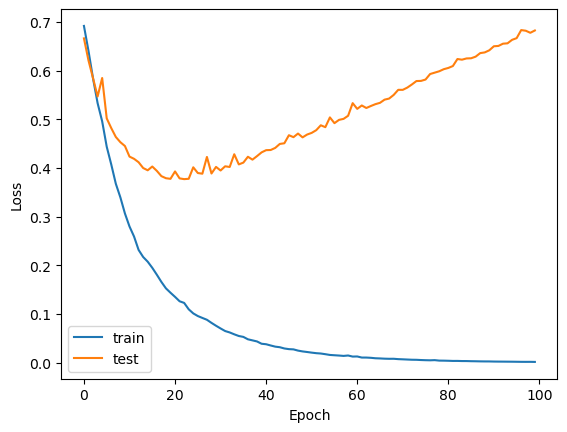

In [142]:
my_nn = DNA_CNN1()
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optimizer = optim.Adam(my_nn.parameters(), lr=0.001)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

dataset_val = TensorDataset(X_test, y_test)
dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)

losses = []
losses_val = []

epochs = 100 # Number of epochs

for epoch in range(epochs):
    
    avg_train_loss = train(my_nn, optimizer, criterion, dataloader)
    avg_val_loss = test(my_nn, criterion, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)

plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
